⏳ Downloading dataset from Kaggle...
📁 Dataset path: /kaggle/input/empathetic-dialogues-facebook-ai/emotion-emotion_69k.csv
Columns in CSV: ['Unnamed: 0', 'Situation', 'emotion', 'empathetic_dialogues', 'labels', 'Unnamed: 5', 'Unnamed: 6']
Train samples: 51708
Test samples:  12928


Map:   0%|          | 0/51708 [00:00<?, ? examples/s]

Map:   0%|          | 0/12928 [00:00<?, ? examples/s]

<ipython-input-8-2d88ae236f17>:147: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Iniciando entrenamiento...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Step,Training Loss
20,3.759300
40,0.984700
60,0.954600
80,0.968000
100,0.868600
120,0.932600
140,0.893100
160,0.886200
180,0.915400
200,0.930200


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Eval metrics: {'eval_loss': 0.8781198859214783, 'eval_runtime': 49.9807, 'eval_samples_per_second': 258.66, 'eval_steps_per_second': 32.332, 'epoch': 1.0}


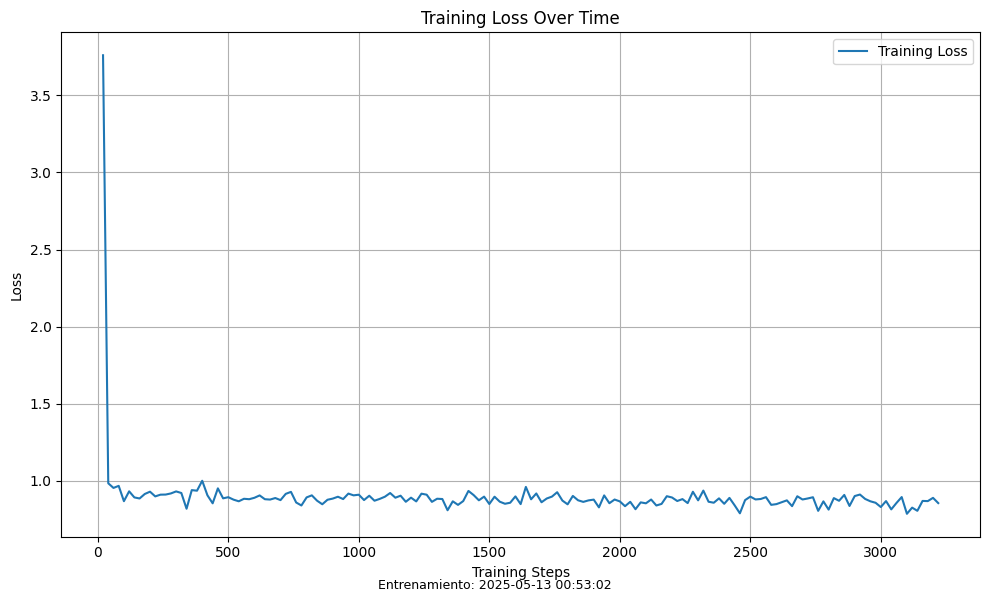

Gráfica de loss guardada en: training_loss.png
📊 Gráfica de entrenamiento generada: training_loss.png
💾 Modelo guardado en: trained_model

🤖 Probando el modelo con ejemplos:

Prompt: I feel really anxious about my upcoming final exam
Respuesta: 

Prompt: I just got promoted at work and I'm so excited!
Respuesta: 

Prompt: I've been feeling down lately and I don't know why
Respuesta: 


In [ ]:
# -*- coding: utf-8 -*-
#Daniela Cascavita
#Angela Paez
#Camila López
"""Proyecto Deep Learning: GPT-Neo con formato Empathetic Dialogues"""

# 0. Instalar dependencias (ejecutar SOLO UNA VEZ)
# !pip install --upgrade transformers datasets pandas scikit-learn kagglehub matplotlib

import os
import pandas as pd
import torch
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    TrainerCallback
)

# Desactivar Weights & Biases
os.environ["WANDB_DISABLED"] = "true"

# Crear una clase de callback personalizada para registrar la pérdida durante el entrenamiento
class LossCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.step_numbers = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.training_losses.append(logs["loss"])
            self.step_numbers.append(state.global_step)

    def plot_loss(self, save_path="loss_plot.png"):
        plt.figure(figsize=(10, 6))
        plt.plot(self.step_numbers, self.training_losses, label='Training Loss')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Time')
        plt.legend()
        plt.grid(True)

        # Añadir información sobre la fecha y hora de entrenamiento
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        plt.figtext(0.5, 0.01, f"Entrenamiento: {timestamp}", ha="center", fontsize=9)

        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()  # <- ESTA LÍNEA MUESTRA LA GRÁFICA
        print(f"Gráfica de loss guardada en: {save_path}")

        return save_path

# 1. Descargar y cargar dataset desde Kaggle
print("⏳ Downloading dataset from Kaggle...")
path = kagglehub.dataset_download("atharvjairath/empathetic-dialogues-facebook-ai")
csv_path = os.path.join(path, "emotion-emotion_69k.csv")
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"Could not find {csv_path}")
print("📁 Dataset path:", csv_path)

# 2. Leer CSV
df = pd.read_csv(csv_path)
print("Columns in CSV:", df.columns.tolist())

# 3. Parsear prompt y reply de la columna cruda 'empathetic_dialogues'
def split_dialogue(s: str):
    # Divide entre el texto antes de "Agent :" y después
    if "Agent :" in s:
        cust, ag = s.split("Agent :", 1)
        return cust.strip(), ag.strip()
    if "Agent:" in s:
        cust, ag = s.split("Agent:", 1)
        return cust.strip(), ag.strip()
    # fallback: todo como prompt, sin reply
    return s.strip(), ""

# Aplica y expande en dos columnas
df[["prompt", "reply"]] = df["empathetic_dialogues"].apply(
    lambda x: pd.Series(split_dialogue(x))
)

# 4. Construir la secuencia para causal LM
model_name = "EleutherAI/gpt-neo-125M"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
sep = tokenizer.eos_token  # normalmente ``

df["text"] = df["prompt"] + sep + "<|agent|> " + df["reply"] + sep

# 5. Crear HuggingFace Dataset y dividir en train/test
hf_dataset = Dataset.from_pandas(df[["text"]])
split      = hf_dataset.train_test_split(test_size=0.2, seed=42)
train_data = split["train"]
test_data  = split["test"]

print(f"Train samples: {len(train_data)}")
print(f"Test samples:  {len(test_data)}")

# 6. Cargar modelo y habilitar optimizaciones
model = AutoModelForCausalLM.from_pretrained(model_name)
# Añadir token de padding si no existe
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": tokenizer.eos_token})
    model.resize_token_embeddings(len(tokenizer))
# Gradient checkpointing
model.gradient_checkpointing_enable()

# 7. Función de tokenización
def tokenize_function(examples):
    toks = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=64
    )
    toks["labels"] = toks["input_ids"]
    return toks

tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_test  = test_data.map(tokenize_function, batched=True)

# 8. Configurar argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    fp16=True,
    logging_dir="./logs",
    logging_steps=20,  # Registrar loss cada 20 pasos para tener suficientes puntos para la gráfica
    save_strategy="epoch",
    save_total_limit=1,
    report_to="none",
    dataloader_num_workers=4,
)

# 9. Inicializar callback para seguimiento de loss
loss_callback = LossCallback()

# 10. Crear Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    callbacks=[loss_callback],  # Añadir nuestro callback personalizado
)

# 11. Entrenar y evaluar (removida la duplicación del entrenamiento)
print("🚀 Iniciando entrenamiento...")
trainer.train()
metrics = trainer.evaluate()
print("Eval metrics:", metrics)

# 12. Generar y guardar la gráfica de loss
loss_plot_path = loss_callback.plot_loss("training_loss.png")
print(f"📊 Gráfica de entrenamiento generada: {loss_plot_path}")

# 13. Guardar el modelo final
trainer.save_model("trained_model")
tokenizer.save_pretrained("trained_model")
print("💾 Modelo guardado en: trained_model")

# 14. Cargar para inferencia
model     = AutoModelForCausalLM.from_pretrained("trained_model", local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained("trained_model", local_files_only=True)

# 15. Función de predicción
def predict(input_text: str, max_new_tokens: int = 50) -> str:
    prompt = input_text + sep + "<|agent|> "
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    out    = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id
    )
    full   = tokenizer.decode(out[0], skip_special_tokens=True)
    # Manejo más robusto de la salida
    if "<|agent|>" in full:
        return full.split("<|agent|>")[1].strip()
    else:
        return full.replace(input_text, "").strip()

# 16. Ejemplos de inferencia
if __name__ == "__main__":
    test_prompts = [
        "I feel really anxious about my upcoming final exam",
        "I just got promoted at work and I'm so excited!",
        "I've been feeling down lately and I don't know why"
    ]

    print("\n🤖 Probando el modelo con ejemplos:")
    for prompt in test_prompts:
        print(f"\nPrompt: {prompt}")
        print(f"Respuesta: {predict(prompt)}")